<a href="https://colab.research.google.com/github/jack-baxter/AAI521-G6-Final/blob/main/copy_of_Group6_project_ORG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<br><center>AAI-521 Final Project
<br><center>Solar Panel Defect Detection
<br><center>Group 6
<br><center>Fall 2025, Dr. Albuyeh
<br><center>Jamshed Nabizada, Jack Baxter, Naima Botros

# Library Imports and Dependency Setup

In [1]:
!pip install torch torchvision torchaudio pandas numpy scikit-learn matplotlib seaborn Pillow

from google.colab import drive
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tqdm import tqdm
import shutil
import time



# Mount Google Drive

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

print("Environment ready.")

# Dataset path
BASE_DIR = "/content/drive/MyDrive/ELPV_SOLAR_DATA/"

if not os.path.exists(BASE_DIR):
    raise FileNotFoundError("BASE_DIR does not exist. Verify your Google Drive path.")

print("BASE_DIR:", BASE_DIR)


Mounted at /content/drive
Environment ready.
BASE_DIR: /content/drive/MyDrive/ELPV_SOLAR_DATA/


In [3]:
# Copy data locally for faster I/O

print("Starting local data copy...")
start_time = time.time()

# Define the local destination path
LOCAL_DIR = "/content/ELPV_SOLAR_DATA/"

# Copy the entire dataset folder recursively
shutil.copytree(BASE_DIR, LOCAL_DIR)

print(f"Copy complete in {time.time() - start_time:.2f} seconds.")

# Update the BASE_DIR variable to point to the fast local copy
BASE_DIR = LOCAL_DIR
print("BASE_DIR updated to local path:", BASE_DIR)

Starting local data copy...
Copy complete in 521.53 seconds.
BASE_DIR updated to local path: /content/ELPV_SOLAR_DATA/


# Data Parsing, DataFrame Construction and Initial Counts

In [4]:
def parse_binary_label(txt_path):
    """
    Converts YOLO labels into a binary classification target:
    - 1 = defective (any YOLO class present)
    - 0 = non-defective (no class entries or missing file)
    """
    if not os.path.exists(txt_path):
        return 0

    with open(txt_path, "r") as f:
        lines = [ln.strip() for ln in f.readlines() if ln.strip()]

    return 1 if len(lines) > 0 else 0


def build_dataframe(root_dir):
    data = []

    for split in ["train", "valid", "test"]:
        img_dir = os.path.join(root_dir, split, "images")
        lbl_dir = os.path.join(root_dir, split, "labels")

        if not os.path.isdir(img_dir):
            continue

        for img_name in os.listdir(img_dir):
            name, ext = os.path.splitext(img_name)
            if ext.lower() not in [".jpg", ".jpeg", ".png"]:
                continue

            img_path = os.path.join(img_dir, img_name)
            txt_path = os.path.join(lbl_dir, name + ".txt")
            label = parse_binary_label(txt_path)

            data.append({
                "image_path": img_path,
                "label": label
            })

    df = pd.DataFrame(data)
    return df

# Build DataFrame
df_full = build_dataframe(BASE_DIR)

if df_full.empty:
    raise SystemExit("No images found. Check dataset structure.")

print("Total images:", len(df_full))
print(df_full.head())

print("\nClass distribution:")
print(df_full['label'].value_counts())


Total images: 7435
                                          image_path  label
0  /content/ELPV_SOLAR_DATA/train/images/DJI_028_...      1
1  /content/ELPV_SOLAR_DATA/train/images/orthomos...      1
2  /content/ELPV_SOLAR_DATA/train/images/DJI_2022...      1
3  /content/ELPV_SOLAR_DATA/train/images/Copy-of-...      1
4  /content/ELPV_SOLAR_DATA/train/images/DJI_2022...      1

Class distribution:
label
1    7332
0     103
Name: count, dtype: int64


- The function: parse_binary_label reads YOLO .txt files: returns 1 if any defect, 0 otherwise.
- The function: build_dataframe scans train/valid/test folders, builds DataFrame with image_path and label.
- Output prints total number of images and counts per class.

# Exploratory Data Analysis (EDA\)

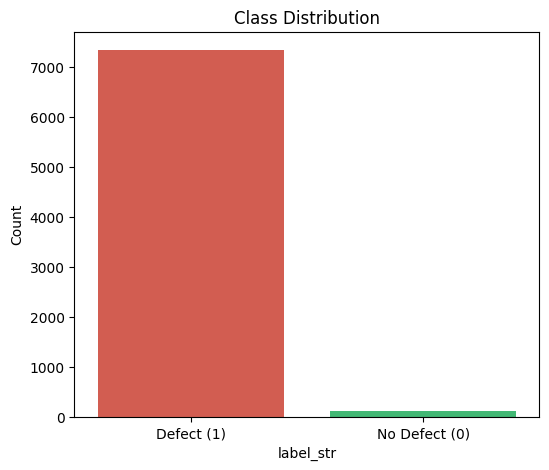

In [5]:
# Map labels to string for display
df_full["label_str"] = df_full["label"].map({0: "No Defect (0)", 1: "Defect (1)"})

plt.figure(figsize=(6,5))
sns.countplot(
    x="label_str",
    data=df_full,
    hue="label_str",
    palette={"No Defect (0)": "#2ecc71", "Defect (1)": "#e74c3c"},
    legend=False
)
plt.title("Class Distribution")
plt.ylabel("Count")
plt.show()


- Maps numeric labels to descriptive strings.
- Removes hue to avoid doubling bars and misrepresentation.
- Ensures the plot correctly shows majority class (1) as expected.

# Split dataset into train/val/test

In [6]:
# Split 80% train, 10% val, 10% test while preserving class ratios
df_train, df_temp = train_test_split(
    df_full, test_size=0.20, stratify=df_full["label"], random_state=42
)
df_val, df_test = train_test_split(
    df_temp, test_size=0.50, stratify=df_temp["label"], random_state=42
)

print("Split sizes:")
print("Train:", len(df_train))
print("Val:  ", len(df_val))
print("Test: ", len(df_test))


Split sizes:
Train: 5948
Val:   743
Test:  744


- Splits dataset while preserving class ratios (stratify).
- Ensures roughly 80% train, 10% validation, 10% test.

# Visual Inspection of Sample Training Images

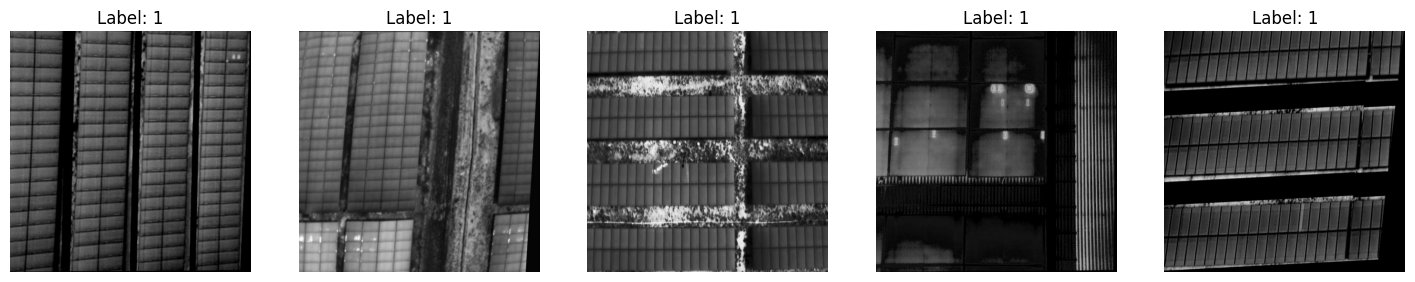

In [7]:
def show_samples(df, n=5):
    samples = df.sample(n, random_state=42)
    fig, axes = plt.subplots(1, n, figsize=(18, 5))

    for i, (_, row) in enumerate(samples.iterrows()):
        img = Image.open(row["image_path"]).convert("RGB")
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {row['label']}")
        axes[i].axis("off")

    plt.show()

show_samples(df_train, n=5)


- Displays random sample images from the training set.
- Helps visually confirm label correctness.

# Data Processing and Augmentation Pipelines

In [8]:
image_size = 256
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    # ENHANCEMENT: Added RandomAffine for geometric augmentation (slight shifts, zooms, and rotation).
    # This simulates minor changes in camera angle or panel mounting.
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    # Standard ImageNet normalization for transfer learning
    transforms.Normalize(mean, std),
])

test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

- Defines image preprocessing and augmentation for train/validation/test sets.
- Training includes flips, rotation, color jitter; test/validation only resize & normalize.

# Dataset and DataLoader

In [9]:
class PVPanelDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["image_path"]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(row["label"], dtype=torch.long)
        return img, label


def collate_remove_none(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None
    return torch.utils.data.dataloader.default_collate(batch)


batch_size = 32
num_workers = 2

train_loader = DataLoader(PVPanelDataset(df_train, train_transform),
                          batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, collate_fn=collate_remove_none)

val_loader = DataLoader(PVPanelDataset(df_val, test_transform),
                        batch_size=batch_size, shuffle=False,
                        num_workers=num_workers, collate_fn=collate_remove_none)

test_loader = DataLoader(PVPanelDataset(df_test, test_transform),
                         batch_size=batch_size, shuffle=False,
                         num_workers=num_workers, collate_fn=collate_remove_none)

print("Dataloaders ready.")


Dataloaders ready.


- The function: PVPanelDataset loads images and labels from a DataFrame.
- The function: collate_remove_none avoids errors if any images are missing.
- DataLoaders are ready for training and evaluation.

#ResNet 18 Initialization

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def initialize_resnet18(num_class=2, freeze=True):
  weights = ResNet18_Weights.IMAGENET1K_V1
  model = resnet18(weights=weights)

  if freeze:
    for p in model.parameters():
      p.requires_grad = False

  model.fc = nn.Linear(model.fc.in_features, num_class)
  return model.to(device)
model = initialize_resnet18()
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 108MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

- Load a pretrained ResNet-18 model with ImageNet weights
- Freez all layers then replaces the final FC layer to match the number of classes

# Class Weight Calculation

In [11]:

counts = df_full["label"].value_counts()
minority = counts.get(0,1)
majority = counts.get(1,1)

weight_for_0 = majority / minority
weight_for_1 = 1.0

class_weights = torch.tensor([weight_for_0, weight_for_1], dtype=torch.float).to(device)
print("Class wieghts", class_weights)

Class wieghts tensor([71.1845,  1.0000])


- Computing how many samples belong to each class (0,1)
- Creates a higher weight for the minority class so the loss function penalizes misclasification of that class more strongly


# Baseline CNN Model

In [12]:
# baseline CNN model with four convolutional layers
# max pooling after each pair
# dropout for regularization
# and two fully connected layers for classification
class BaselineCNN(nn.Module):

    # function to initialize all convolutional, pooling, dropout,
    # and fully connected layers
    def __init__(self, num_classes=2):
        super(BaselineCNN, self).__init__()

        # first convolution block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # second convolution block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        # regularization
        self.dropout = nn.Dropout(0.3)

        # fully connected layers
        self.fc1 = nn.Linear(256 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)

    # function to define forward pass
    def forward(self, x):

        # conv blocks
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        # flatten feature maps
        x = x.view(x.size(0), -1)

        # fully connected classifier
        x = F.relu(self.fc1(self.dropout(x)))
        x = self.fc2(x)

        return x


# Initialize Baseline CNN

In [13]:
# running this to ensure we are running GPU for training
# as runtime can be long
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# initialize the baseline model, and move it to the selected device (GPU)
baseline_model = BaselineCNN(num_classes=2).to(device)
print(baseline_model) # print model architecture


BaselineCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=65536, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


#Training and Validation

In [14]:
# function to train our model
def train_model(
    model,
    train_loader,
    val_loader,
    num_epochs=10,
    lr=0.001,
    class_weights=None
):

    # loss function and optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # track loss and accuracy across epich
    history = {"train_loss": [],
               "val_loss": [],
               "train_acc": [],
               "val_acc": []
              }

    # iterate trhough epochs for training
    for epoch in range(num_epochs):
        model.train() # set the model to training mode
        running_loss = 0
        correct = 0
        total = 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        # our training loop
        for images, labels in loop:

            # move input images and labels to our device (GPU)
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad() # reset gradients
            outputs = model(images) # forward pass
            loss = criterion(outputs, labels)
            loss.backward() # backdrop
            optimizer.step() # update weights

            # accumulate total loss for the epoch
            running_loss += loss.item() * images.size(0)

            # compute our training accuracy
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / total
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        # validation loop
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        # no gradient updates during validation,
        # disables backdrop to speed up inference
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)

                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        # compute average validation loss and overall validation accuracy
        val_loss /= val_total
        val_acc = val_correct / val_total

        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    return history

# Model Training

In [15]:
# train our model
history_baseline = train_model(
    baseline_model,
    train_loader,
    val_loader,
    num_epochs=10,
    lr=0.0005,
    class_weights=class_weights
)



Epoch 1/10: 100%|██████████| 186/186 [24:04<00:00,  7.76s/it]


Epoch 1 | Train Acc: 0.9810 | Val Acc: 0.9865


Epoch 2/10: 100%|██████████| 186/186 [23:37<00:00,  7.62s/it]


Epoch 2 | Train Acc: 0.9862 | Val Acc: 0.9865


Epoch 3/10: 100%|██████████| 186/186 [23:16<00:00,  7.51s/it]


Epoch 3 | Train Acc: 0.9862 | Val Acc: 0.9865


Epoch 4/10: 100%|██████████| 186/186 [23:49<00:00,  7.69s/it]


Epoch 4 | Train Acc: 0.9862 | Val Acc: 0.9865


Epoch 5/10: 100%|██████████| 186/186 [24:09<00:00,  7.79s/it]


Epoch 5 | Train Acc: 0.9862 | Val Acc: 0.9865


Epoch 6/10: 100%|██████████| 186/186 [24:01<00:00,  7.75s/it]


Epoch 6 | Train Acc: 0.9862 | Val Acc: 0.9865


Epoch 7/10: 100%|██████████| 186/186 [23:59<00:00,  7.74s/it]


Epoch 7 | Train Acc: 0.9862 | Val Acc: 0.9865


Epoch 8/10: 100%|██████████| 186/186 [24:34<00:00,  7.93s/it]


Epoch 8 | Train Acc: 0.9862 | Val Acc: 0.9865


Epoch 9/10: 100%|██████████| 186/186 [24:20<00:00,  7.85s/it]


Epoch 9 | Train Acc: 0.9862 | Val Acc: 0.9865


Epoch 10/10: 100%|██████████| 186/186 [24:08<00:00,  7.79s/it]


Epoch 10 | Train Acc: 0.9862 | Val Acc: 0.9865


# Prediction Collection Function for Evaluation

In [16]:
# this function is to run the model in evaluation mode
# and collect all predicitions that are true labels
def get_predictions(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad(): # disable gradients for faster inference
        for images, labels in loader:
            images = images.to(device) # move batch to device
            outputs = model(images) # forward pass
            _, preds = outputs.max(1) # get predicted class indices

            # convert tensors to numpy arrays (required for metrics)
            # and store predictions and true labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_labels), np.array(all_preds)


# Compute Classification Metrics and Confusion Matrix

In [17]:
# get all true labels and model predictions from the test set
y_true, y_pred = get_predictions(baseline_model, test_loader)

# generate/print precision, recall, F1 scores for each class
print("Classification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=["Healthy", "Defect"],
    # FIX: Explicitly set zero_division=0 to suppress the warning
    zero_division=0
))

# compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm # call to display CM

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00        11
      Defect       0.99      1.00      0.99       733

    accuracy                           0.99       744
   macro avg       0.49      0.50      0.50       744
weighted avg       0.97      0.99      0.98       744



array([[  0,  11],
       [  0, 733]])

# Visualize Confusion Matrix (Heatmap)

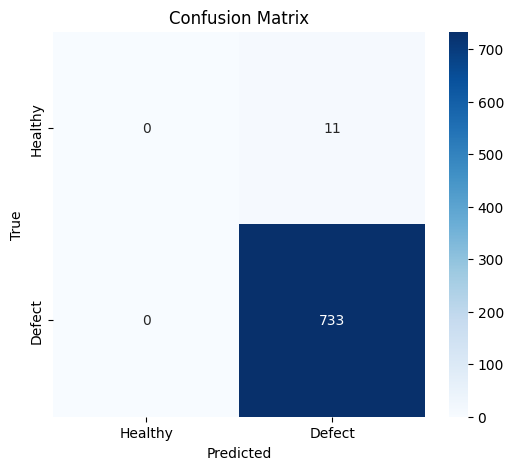

In [18]:
# plot our confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Healthy", "Defect"],
            yticklabels=["Healthy", "Defect"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Visualization Function: Show Misclassified Samples

In [21]:
# this function will display the sample images the model misclassified
import torch
import matplotlib.pyplot as plt

def show_incorrect_predictions(model, loader, num_images=10):
    model.eval()

    # ImageNet normalization values used by ResNet18
    mean_t = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std_t = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    incorrect_images = 0

    with torch.no_grad():
        for imgs, labels in loader:
            # Move data to the same device as the model
            imgs = imgs.to(next(model.parameters()).device)
            labels = labels.to(next(model.parameters()).device)

            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)

            for img, label, pred in zip(imgs, labels, preds):
                if label != pred:
                    # Move image back to CPU for visualization
                    img = img.cpu()

                    # Denormalize: (img * std) + mean
                    img_denorm = img * std_t + mean_t
                    img_disp = img_denorm.permute(1, 2, 0).numpy()

                    # Show image
                    plt.figure(figsize=(3, 3))
                    plt.imshow(img_disp)
                    plt.axis('off')
                    plt.title(f"True: {label.item()}, Pred: {pred.item()}")
                    plt.show()

                    incorrect_images += 1
                    if incorrect_images >= num_images:
                        return


# Display Incorrect Test Predictions

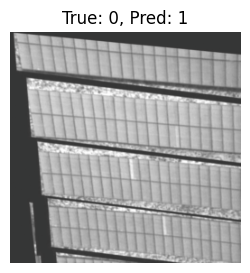

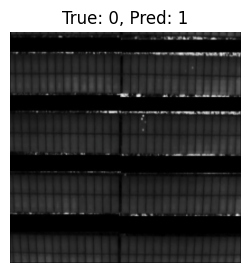

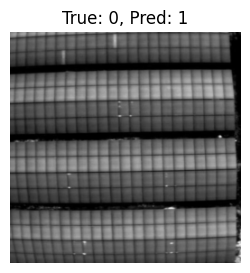

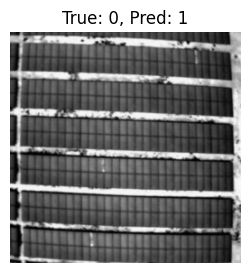

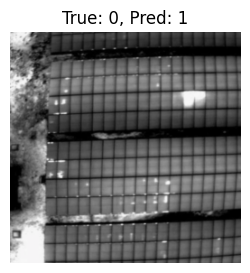

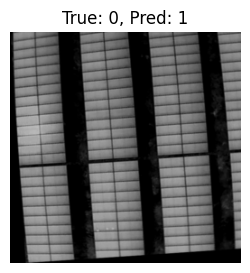

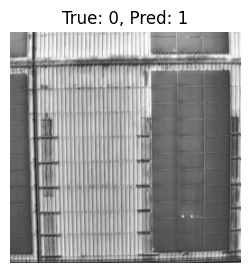

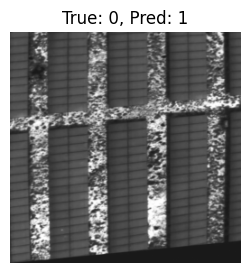

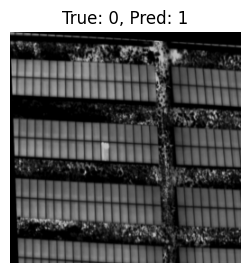

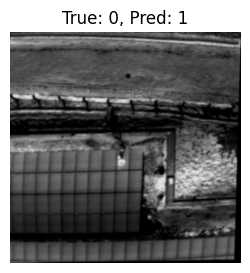

In [22]:
show_incorrect_predictions(baseline_model, test_loader)

# Visualization Function: Show Correctly Classified Samples

In [25]:
# this function will display the sample images the model classified correctly
def show_correct_predictions(model, loader, num_images=10):
    model.eval()

    # ImageNet normalization values (ResNet18 default)
    mean_t = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std_t = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

    correct_images = 0

    with torch.no_grad():
        for imgs, labels in loader:
            # Move images to the same device as the model
            imgs = imgs.to(next(model.parameters()).device)
            labels = labels.to(next(model.parameters()).device)

            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)

            for img, label, pred in zip(imgs, labels, preds):
                if label == pred:  # correct prediction
                    # Move img back to CPU
                    img = img.cpu()

                    # Denormalize
                    img_denorm = img * std_t + mean_t
                    img_disp = img_denorm.permute(1, 2, 0).numpy()

                    plt.figure(figsize=(3,3))
                    plt.imshow(img_disp)
                    plt.axis('off')
                    plt.title(f"Correct — Class: {label.item()}")
                    plt.show()

                    correct_images += 1
                    if correct_images >= num_images:
                        return

# Display Correct Test Predictions

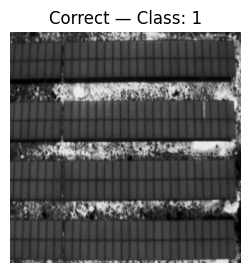

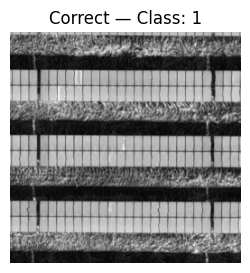

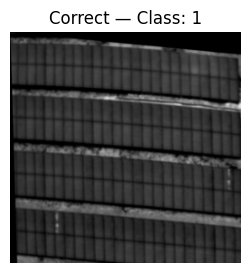

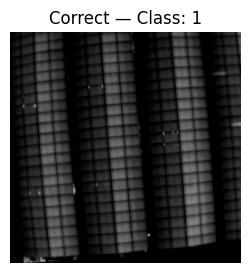

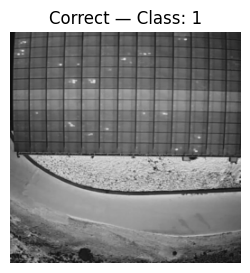

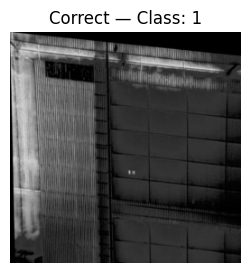

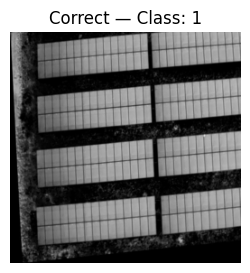

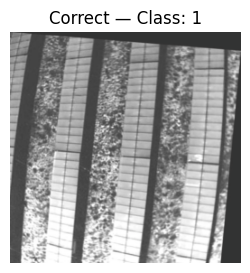

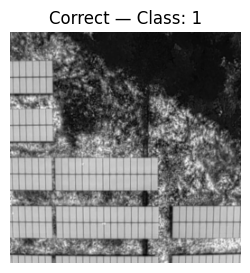

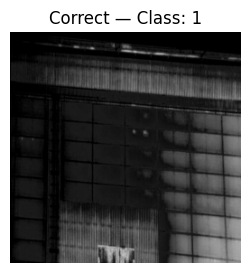

In [26]:
show_correct_predictions(baseline_model, test_loader)

# Evaluation Function: Plot ROC Curve and AUC

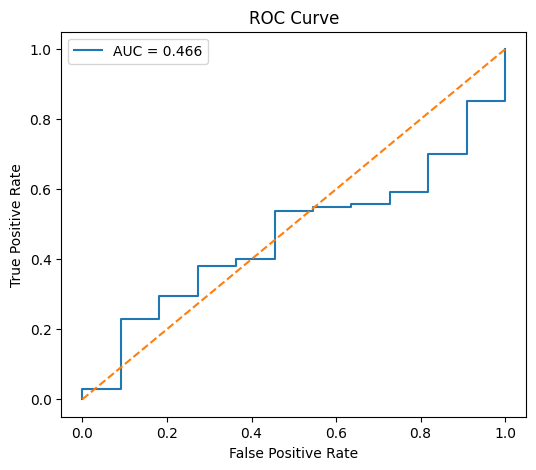

In [27]:
# function to plot ROC curve
def plot_roc(model, loader):
    model.eval()
    probs = []
    labels = []

    with torch.no_grad(): # disable gradients for faster inference
        for images, lbls in loader:
            images = images.to(device) # move to device
            outputs = model(images) # forward pass

            # compute softmax probabilities
            softmax = torch.softmax(outputs, dim=1)
            probs.extend(softmax[:,1].cpu().numpy())  # probability of class 1
            labels.extend(lbls.numpy())

    # compute ROC curve points and area under the curve
    fpr, tpr, _ = roc_curve(labels, probs)
    roc_auc = auc(fpr, tpr)

    # plot our ROC curve
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1], [0,1], '--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

plot_roc(baseline_model, test_loader)